In [59]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.optimize import curve_fit
import statsmodels.api as sm
import math
import ipympl

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

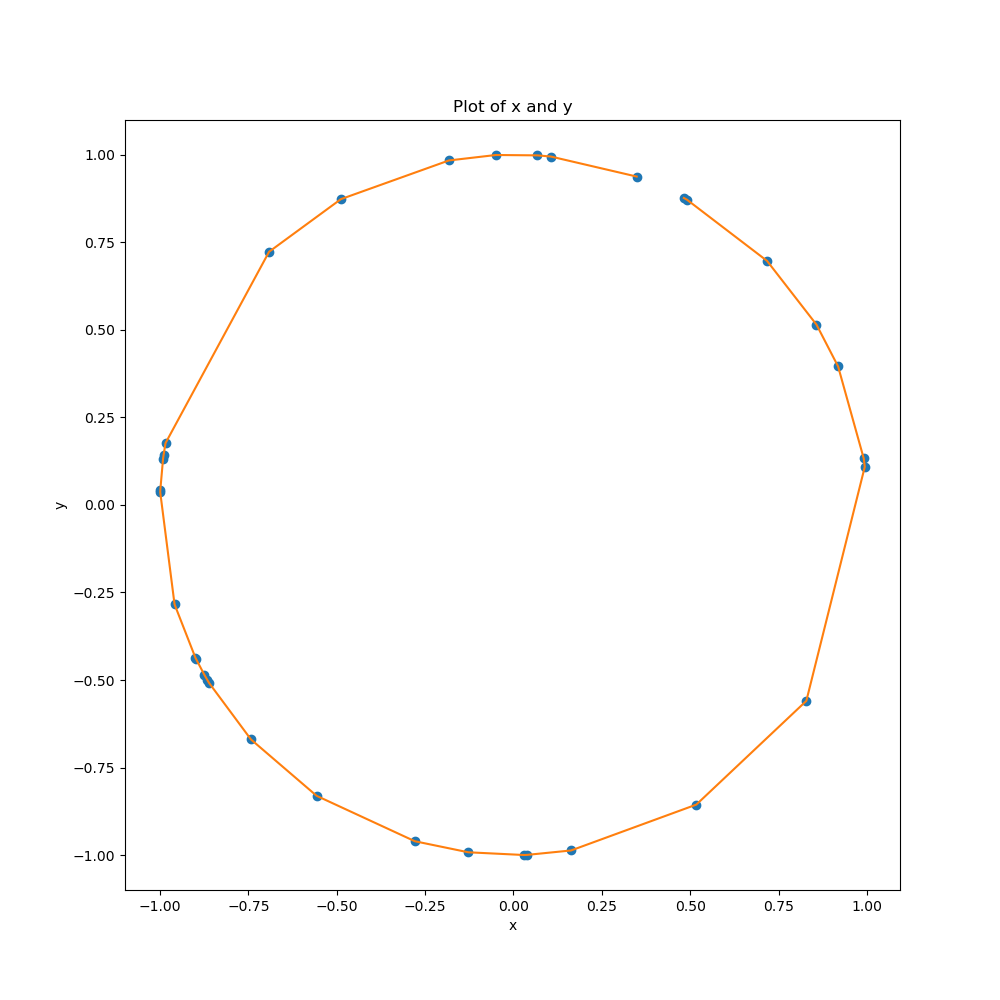

In [60]:
fig = plt.figure(figsize=(10, 10))

x, y = np.loadtxt("../data/ex10_atlas_circle.dat", unpack=True, usecols=(1, 2))

plt.plot(x, y, marker='o', linestyle='None')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of x and y')

x1, y1 = np.loadtxt("../data/ex10_champion_circle.dat", unpack=True, usecols=(1, 2))

plt.plot(x1, y1)
plt.show()

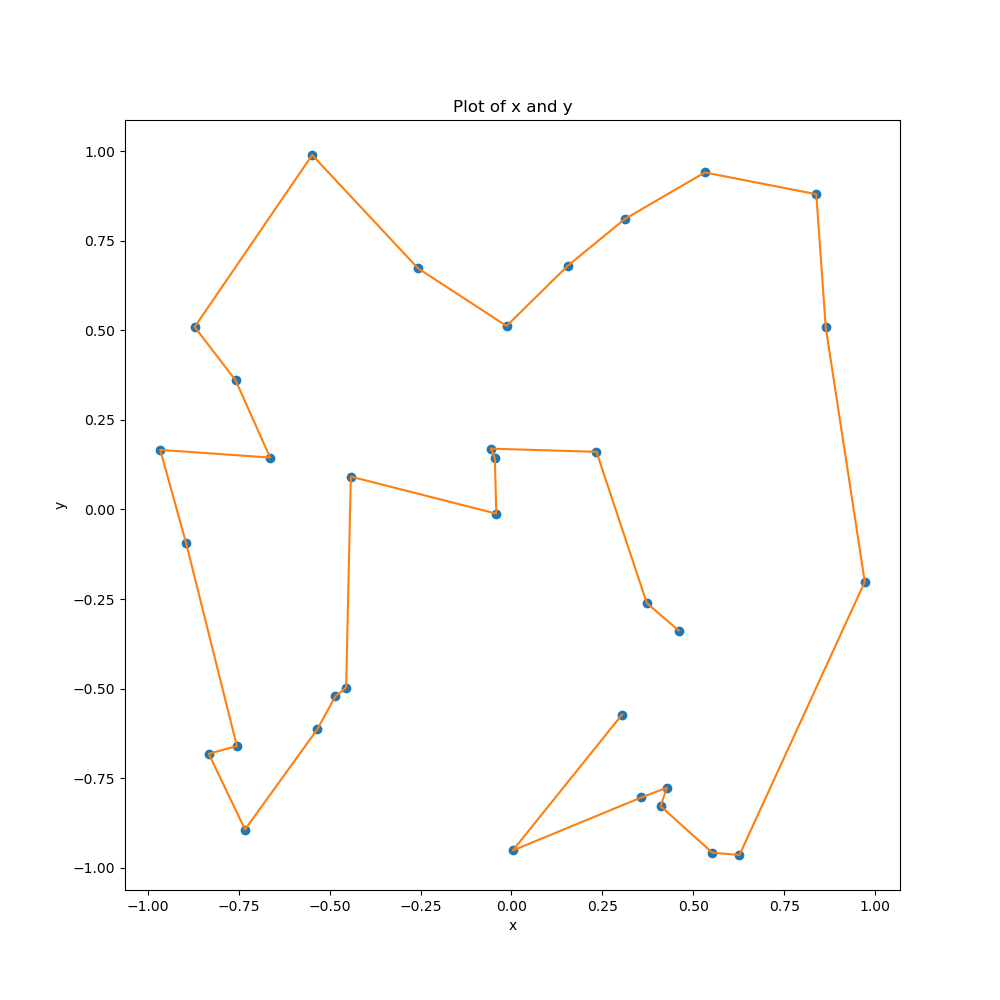

In [61]:
fig = plt.figure(figsize=(10, 10))

x, y = np.loadtxt("../data/ex10_atlas_square.dat", unpack=True, usecols=(1, 2))

plt.plot(x, y, marker='o', linestyle='None')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of x and y')

x1, y1 = np.loadtxt("../data/ex10_champion_square.dat", unpack=True, usecols=(1, 2))

plt.plot(x1, y1)
plt.show()

110


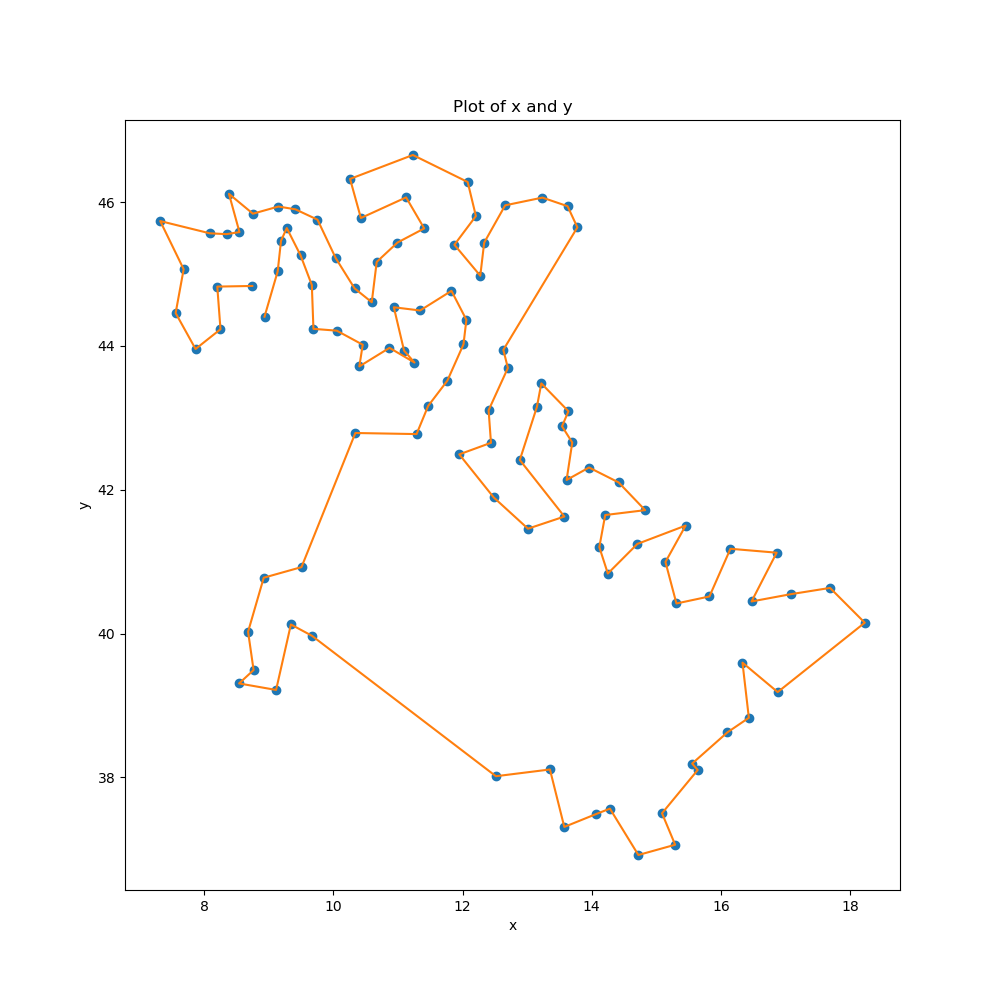

In [62]:
fig = plt.figure(figsize=(10, 10))

# x, y = np.loadtxt("../data/ex10_atlas_provita.dat", unpack=True, usecols=(1, 2))
x, y = np.loadtxt("../exercise_10/cap_prov_ita.dat", unpack=True, usecols=(0, 1))
print(x.size)
plt.plot(x, y, marker='o', linestyle='None')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of x and y')

x1, y1 = np.loadtxt("../data/ex10_champion_provita.dat", unpack=True, usecols=(1, 2))

plt.plot(x1, y1)
plt.show()

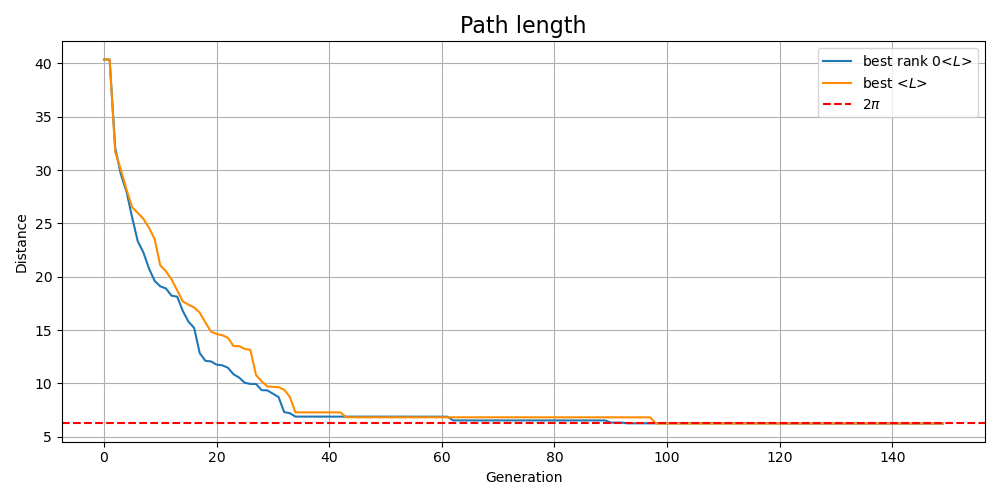

In [68]:
plt.figure(figsize = (10,5))
n_gen, best_len, best_half_len = np.loadtxt("../data/ex09_values_circle.dat", unpack = True, usecols = (0, 1, 2))
best_len0, best_half_len0 = np.loadtxt("../data/ex10_r2_values_circle.dat", unpack = True, usecols = (1, 2))
np.sqrt(best_len)
np.sqrt(best_half_len)
np.sqrt(best_len0)
np.sqrt(best_half_len0)
# plt.plot(n_gen[:150], best_len[:150], label = r'Best $L$')
# plt.plot(n_gen[:150], best_len0[:150], label = r'Best rank 0 $L$')
plt.plot(n_gen[:150], best_half_len0[:150], label = r'best rank 0<$L$>')
plt.plot(n_gen[:150], best_half_len[:150], label = r'best <$L$>', color = 'darkorange')
plt.axhline(y = 2*np.pi, color = 'r', linestyle = '--', label = r'$2\pi$')
plt.title('Path length', fontsize = 16)
plt.ylabel('Distance')
plt.xlabel('Generation')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()